In [1]:
import torch
import numpy as np
import matplotlib.pylab as plt
import cv2

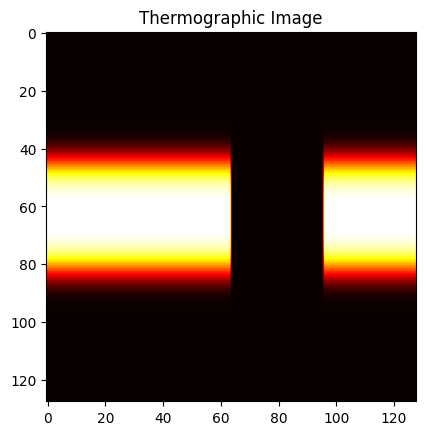

In [2]:
def makeThermography(image_height=128, image_width=128):
    x = np.linspace(-1, 1, image_width)
    y = np.linspace(-1, 1, image_height)
    X, Y = np.meshgrid(x, y)

    gradient = np.exp(-100 * Y**4)

    mask = (X < 0) | (X>0.5)
    thermographic_image = np.zeros_like(gradient)
    thermographic_image[mask] = gradient[mask]

    return thermographic_image

result_image = makeThermography()

plt.imshow(result_image, cmap='hot')
plt.title("Thermographic Image")
plt.show()

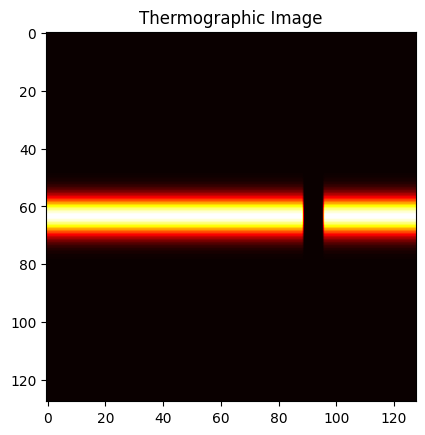

In [3]:
def makeThermography(image_height=128, image_width=128):
    x = np.linspace(-1, 1, image_width)
    y = np.linspace(-1, 1, image_height)
    X, Y = np.meshgrid(x, y)

    gradient = np.exp(-100 * Y**2)

    mask = (X < 0.4) | (X>0.5)
    thermographic_image = np.zeros_like(gradient)
    thermographic_image[mask] = gradient[mask]

    return thermographic_image

result_image = makeThermography()

plt.imshow(result_image, cmap='hot')
plt.title("Thermographic Image")
plt.show()

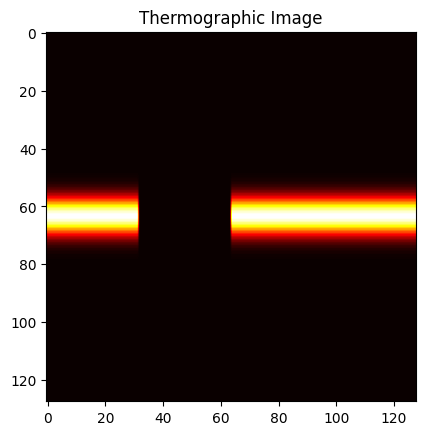

In [4]:
def makeThermography(image_height=128, image_width=128):
    x = np.linspace(-1, 1, image_width)
    y = np.linspace(-1, 1, image_height)
    X, Y = np.meshgrid(x, y)

    gradient = np.exp(-100 * Y**2)

    mask = (X < -0.5) | (X>0)
    thermographic_image = np.zeros_like(gradient)
    thermographic_image[mask] = gradient[mask]

    return thermographic_image

result_image = makeThermography()

plt.imshow(result_image, cmap='hot')
plt.title("Thermographic Image")
plt.show()

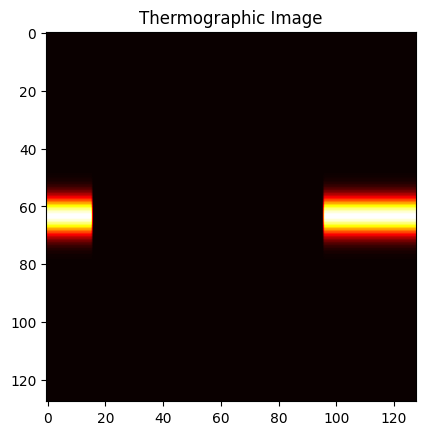

In [5]:

def makeThermography(image_height=128, image_width=128):
    x = np.linspace(-1, 1, image_width)
    y = np.linspace(-1, 1, image_height)
    X, Y = np.meshgrid(x, y)

    gradient = np.exp(-100 * Y**2)

    mask = (X < -0.75) | (X>0.5)
    thermographic_image = np.zeros_like(gradient)
    thermographic_image[mask] = gradient[mask]

    return thermographic_image

result_image = makeThermography()

plt.imshow(result_image, cmap='hot')
plt.title("Thermographic Image")
plt.show()

In [6]:
#helpers for blob segmentation
def blob_segmentation(image):
    binary_image = image > 0.5
    blob_image, num_labels = label_connected_components(binary_image)
    regions = regionprops(blob_image, num_labels)
    return blob_image, regions

def label_connected_components(binary_image):
    blob_image = np.zeros_like(binary_image)
    current_label = 1
    labels = {}

    for i in range(binary_image.shape[0]):
        for j in range(binary_image.shape[1]):
            if binary_image[i, j] == 1 and blob_image[i, j] == 0:
                dfs(i, j, current_label, blob_image, binary_image, labels)
                current_label += 1

    return blob_image, current_label - 1

def dfs(i, j, current_label, blob_image, binary_image, labels):
    if i < 0 or i >= binary_image.shape[0] or j < 0 or j >= binary_image.shape[1]:
        return

    if binary_image[i, j] == 1 and blob_image[i, j] == 0:
        blob_image[i, j] = current_label
        labels[current_label] = labels.get(current_label, []) + [(i, j)]

        for x in range(-1, 2):
            for y in range(-1, 2):
                dfs(i + x, j + y, current_label, blob_image, binary_image, labels)

def regionprops(blob_image, num_labels):
    regions = []

    for label in range(1, num_labels + 1):
        indices = np.where(blob_image == label)

        if indices[0].size == 0 or indices[1].size == 0:
            continue

        min_row, min_col = np.min(indices[0]), np.min(indices[1])
        max_row, max_col = np.max(indices[0]), np.max(indices[1])
        centroid = ((max_row + min_row) / 2, (max_col + min_col) / 2)

        regions.append({'label': label, 'centroid': centroid})

    return regions

In [7]:
def EndToEndDistance(blob_image):
    binary_image = blob_image.astype(np.uint8)
    _, labels, _, _ = cv2.connectedComponentsWithStats(binary_image)
    print("Total Blobs are : ", len(np.unique(labels)) - 1)

    if len(np.unique(labels)) >= 2:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(binary_image, cmap='gray')
        plt.title('Binary Image')

        plt.subplot(1, 2, 2)
        plt.imshow(binary_image, cmap='gray')

        all_distances = []

        for i in range(1, len(np.unique(labels))):
            for j in range(i + 1, len(np.unique(labels))):
                blob_mask1 = (labels == i).astype(np.uint8)
                blob_mask2 = (labels == j).astype(np.uint8)

                contours1, _ = cv2.findContours(blob_mask1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                contours2, _ = cv2.findContours(blob_mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                if contours1 and contours2:
                    hull1 = cv2.convexHull(contours1[0])
                    hull2 = cv2.convexHull(contours2[0])

                    points_hull1 = hull1[:, 0, :]
                    points_hull2 = hull2[:, 0, :]

                    distance = np.linalg.norm(points_hull1[:, np.newaxis, :] - points_hull2, axis=2)
                    min_distance = np.min(distance)

                    all_distances.append(min_distance)

                    for d in distance:
                        plt.plot(points_hull1[:, 0], points_hull1[:, 1], 'r-')
                        plt.plot(points_hull2[:, 0], points_hull2[:, 1], 'b-')

        if all_distances:
            print("All Distances:", all_distances)
            plt.show()
        else:
            print("Contours not found for one or more blobs.")
    else:
        print("There are less than two blobs in the image.")

In [8]:
def CentroidDistance(blob_image):
    binary_image = blob_image.astype(np.uint8)
    _, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image)

    if len(centroids) >= 2:
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(binary_image, cmap='gray')
        plt.title('Binary Image')

        blob_image_rgb = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2RGB)
        
        for i in range(1, len(centroids)):
            cv2.circle(blob_image_rgb, (int(centroids[i][0]), int(centroids[i][1])), 5, (255, 0, 0), -1)
        
        plt.subplot(1, 3, 2)
        plt.imshow(blob_image_rgb)
        plt.title('Connected Centroids')

        all_distances = []
        
        for i in range(1, len(centroids)):
            for j in range(i + 1, len(centroids)):
                centroid_blob1 = centroids[i]
                centroid_blob2 = centroids[j]
                
                distance_between_blobs = np.linalg.norm(centroid_blob1 - centroid_blob2)
                all_distances.append(distance_between_blobs)

                plt.subplot(1, 3, 3)
                plt.imshow(blob_image_rgb)
                plt.plot([centroid_blob1[0], centroid_blob2[0]], [centroid_blob1[1], centroid_blob2[1]], 'r-')
                plt.title('Distances between Centroids')

        if all_distances:
            print("All Distances between Centroids:", all_distances)
            plt.show()
        else:
            print("Distances not found for one or more blobs.")
    else:
        print("There are less than two blobs in the image.")

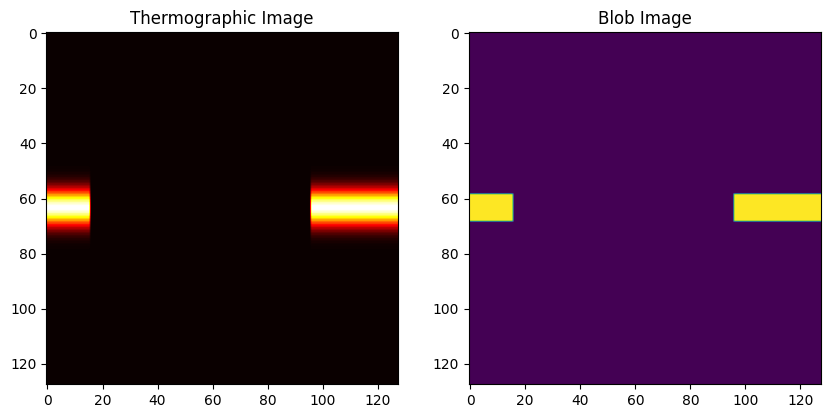

In [9]:
blob_image, regions = blob_segmentation(result_image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(result_image, cmap='hot')
plt.title("Thermographic Image")

plt.subplot(1, 2, 2)
plt.imshow(blob_image, cmap='viridis')
plt.title("Blob Image")
plt.show()


In [16]:
print("Blob Image : \n", blob_image)

Blob Image : 
 [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


Total Blobs are :  2
All Distances: [81.0]


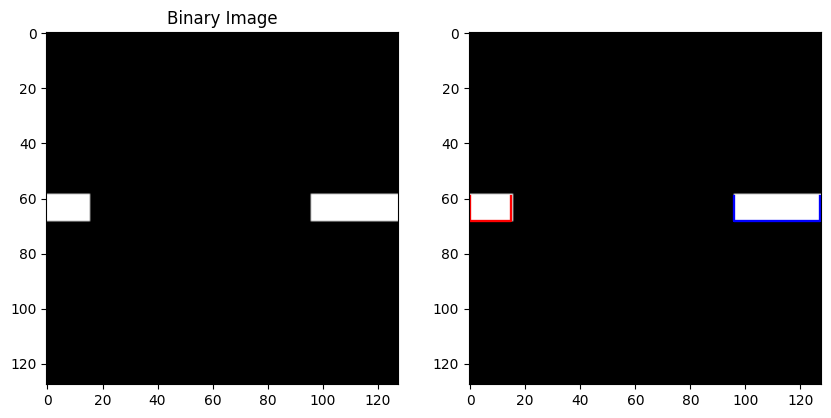

In [10]:
EndToEndDistance(blob_image)

All Distances between Centroids: [104.0]


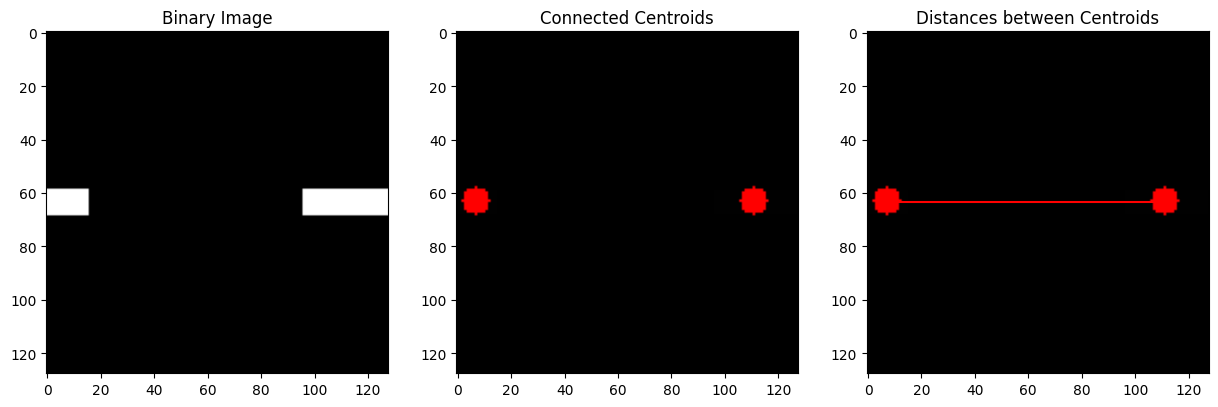

In [11]:
CentroidDistance(blob_image)

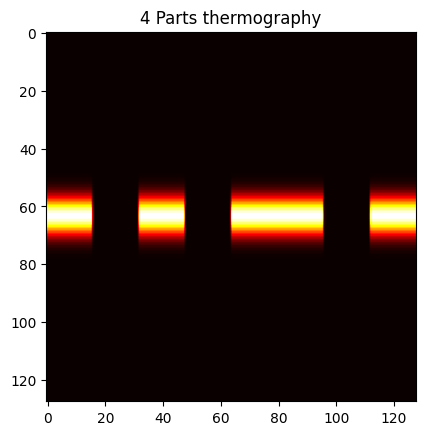

In [12]:
def makeThermography(image_height=128, image_width=128):
    x = np.linspace(-1, 1, image_width)
    y = np.linspace(-1, 1, image_height)
    X, Y = np.meshgrid(x, y)

    gradient = np.exp(-100 * Y**2)

    mask = (X < -0.75) | ((X< -0.25) & (X>-0.50)) | ((X > 0) & (X <= 0.5)) | ((X>0.75) & (X <= 1))
    thermographic_image = np.zeros_like(gradient)
    thermographic_image[mask] = gradient[mask]

    return thermographic_image

result_image = makeThermography()

plt.imshow(result_image, cmap='hot')
plt.title("4 Parts thermography")
plt.show()

(128, 128)


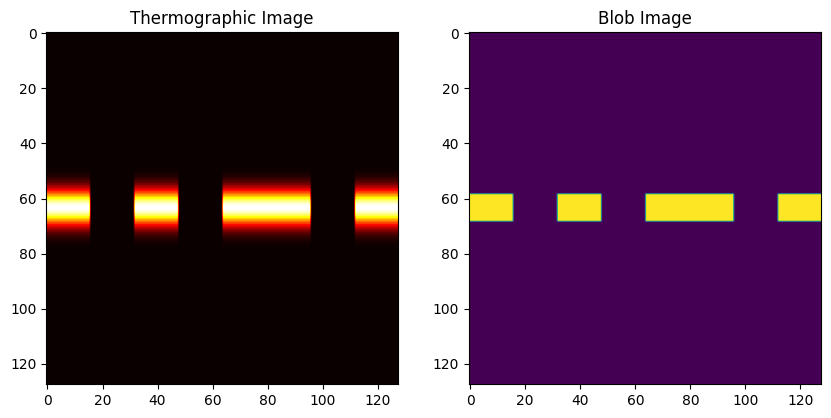

In [13]:
result_image = makeThermography()
print(result_image.shape)
blob_image, regions = blob_segmentation(result_image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(result_image, cmap='hot')
plt.title("Thermographic Image")

plt.subplot(1, 2, 2)
plt.imshow(blob_image, cmap='viridis')
plt.title("Blob Image")
plt.show()


Total Blobs are :  4
All Distances: [17.0, 49.0, 97.0, 17.0, 65.0, 17.0]


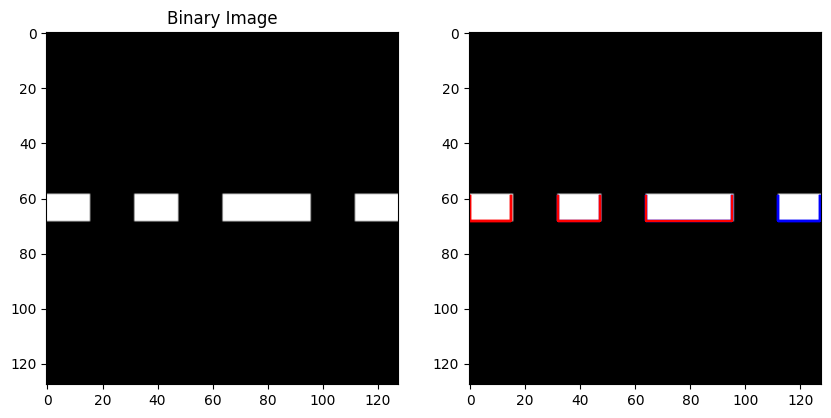

In [14]:
EndToEndDistance(blob_image)

All Distances between Centroids: [32.0, 72.0, 112.0, 40.0, 80.0, 40.0]


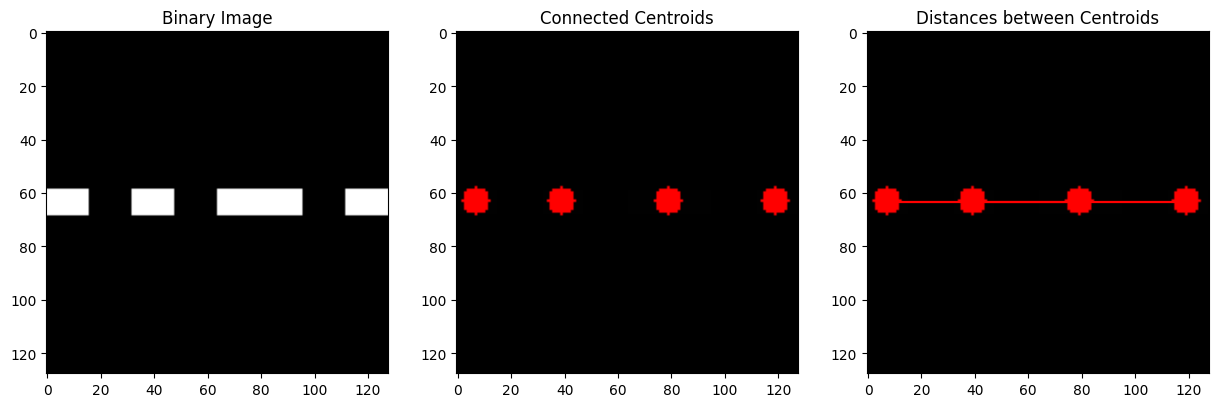

In [15]:
CentroidDistance(blob_image)